<a href="https://colab.research.google.com/github/daspartho/DiffEdit/blob/main/DiffEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting things up

### Install and imports

In [244]:
!pip install diffusers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [245]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display
import logging
from pathlib import Path
from huggingface_hub import notebook_login

logging.disable(logging.WARNING)

if not (Path.home()/'.huggingface'/'token').exists(): 
    notebook_login()

### Loading the Models

In [246]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

### Useful functions

#### Functions to convert image to latents

In [247]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to("cuda").half())
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

#### Function to process and show image

In [248]:
def show_img(img):
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    display.display(Image.fromarray(img[0]))

#### Funtion to convert prompt into text embeddings

In [249]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to("cuda")
    )[0].half()

    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to("cuda")
    )[0].half()

    return torch.cat([uncond_embedding, text_embedding])

## Step 1: Get the Mask

### Denoising function (basically Img2Img pipeline)

In [250]:
def denoise(
    prompt,
    img, 
    steps=50,
    guidance_scale=7.5, 
    start_step=25,
    seed=32
    ):

    prompt = [prompt]
    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    width, height = img.size
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to("cuda").half()

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > start_step:
            input = torch.cat([latents]*2)
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        img = vae.decode(latents).sample
    return img

### Get the input image

In [251]:
!curl --output test.jpg 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fthumbs.dreamstime.com%2Fb%2Fyard-dog-sitting-bench-small-summer-green-park-33146880.jpg&f=1&nofb=1&ipt=4d226c30ea826ad15d591372c9c6276206e8d2f5487e1a1432b13e7eda53f80d&ipo=images'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84435    0 84435    0     0   455k      0 --:--:-- --:--:-- --:--:--  453k


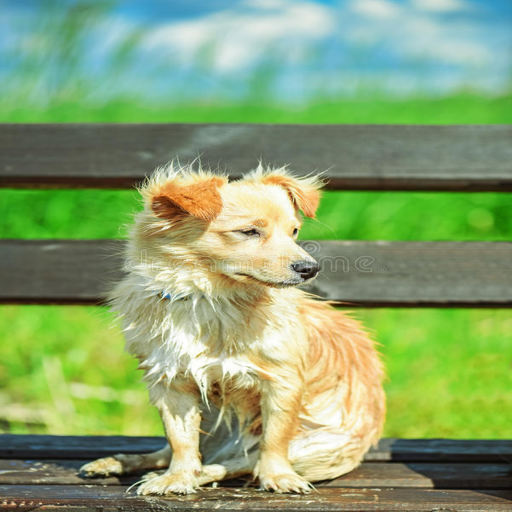

In [252]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

### Denoising input image

In [253]:
ref = "a dog sitting on a bench"
query = "a cat sitting on a bench"

#### Denoising on query text

  0%|          | 0/50 [00:00<?, ?it/s]

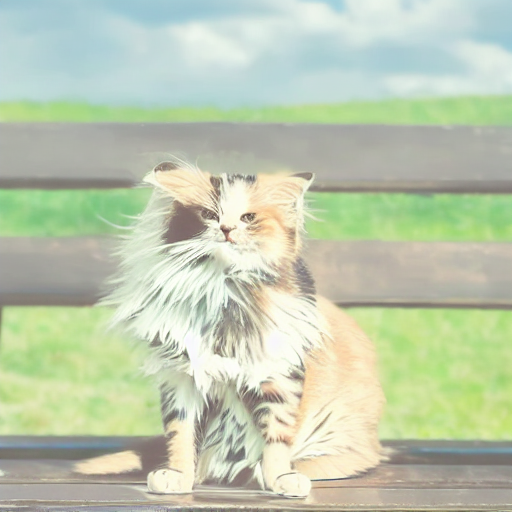

In [254]:
query_img = denoise(query,img)
show_img(query_img)

#### Denoising on reference text

  0%|          | 0/50 [00:00<?, ?it/s]

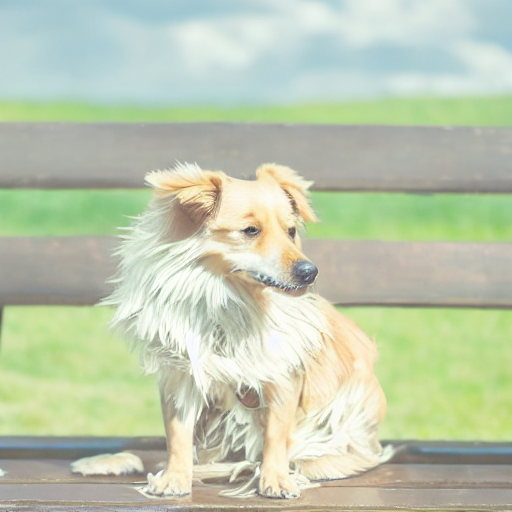

In [255]:
ref_img = denoise(ref, img)
show_img(ref_img)

### Getting difference between the denoised images

#### Taking the difference

In [256]:
diff_img = query_img-ref_img
diff_img.shape

torch.Size([1, 3, 512, 512])

#### Taking mean of all channels

In [257]:
diff_mean = diff_img.mean(dim=1)
diff_mean.shape

torch.Size([1, 512, 512])

#### normalize (between 0 to 1)

In [258]:
diff_normed = (diff_mean - diff_mean.min())/(diff_mean - diff_mean.min()).max()
diff_normed

tensor([[[0.4878, 0.4875, 0.4871,  ..., 0.4934, 0.4937, 0.4946],
         [0.4878, 0.4875, 0.4875,  ..., 0.4929, 0.4929, 0.4937],
         [0.4871, 0.4875, 0.4875,  ..., 0.4927, 0.4922, 0.4937],
         ...,
         [0.4324, 0.4429, 0.4495,  ..., 0.5078, 0.5210, 0.5303],
         [0.4248, 0.4377, 0.4395,  ..., 0.5103, 0.5361, 0.5298],
         [0.4304, 0.4648, 0.4468,  ..., 0.3774, 0.3840, 0.4358]]],
       device='cuda:0', dtype=torch.float16)

#### binarize (0 or 1)

In [259]:
diff_bin=(diff_normed>0.5).float()
diff_bin

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

#### Let's see how it turned out

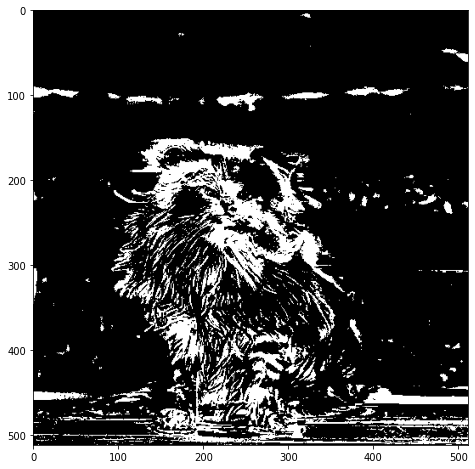

In [260]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(diff_bin.squeeze().cpu(), cmap="gray")
plt.show()